In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import ipywidgets as widgets

sns.set()

## Exploratory Data Analysis
### Overview

In [11]:
with pd.ExcelFile("data/can.xlsx") as xls:
    df_prices = pd.read_excel(xls,"Price",index_col=0,parse_dates=True)
    df_prices.columns = df_prices.columns.map(str)

with pd.ExcelFile("data/can.xlsx") as xls:
    df_info = pd.read_excel(xls,"Info",index_col=0)
    df_info.index = df_info.index.map(str)

df_info.head()

,ISIN CODE,NAME,COUPON,AMOUNT ISSUED,COUPON DATES,INDEX LINKED COUP,COUPONS PER YEAR,1ST COUPON VALUE,OTHER YIELD,RED. YIELD,CURRENCY,START DATE,MATURITY YEAR,START YEAR,ACTIVE,REDEMPTION DATE
Type,,,,,,,,,,,,,,,,
846111,CA135087VS05,CANADA 1995 4 1/4% 01/12/26 INDXLK.,7.6333,5250000.0,"01.06,01.12",4.25,2,2.06100,2.241,NaN,C$,07/12/1995,2026,1995,Active,01/12/26
610286,CA135087WV25,CANADA 1999 4% 01/12/31 INDXLK.,6.9046,5800000.0,"01.06,01.12",4.00,2,0.93150,2.129,NaN,C$,08/03/1999,2031,1999,Active,01/12/31
248402,CA135087XQ21,CANADA 2003 3% 01/12/36 INDXLK.,4.5947,5850000.0,"01.06,01.12",3.00,2,1.43840,2.100,NaN,C$,09/06/2003,2036,2003,Active,01/12/36
97059Q,CA135087YK42,CANADA 2007 2% 01/12/41 INDXLK.,2.8366,6550000.0,"01.06,01.12",2.00,2,0.98630,2.122,NaN,C$,04/06/2007,2041,2007,Active,01/12/41
5653HV,CA135087ZH04,CANADA 2010 1 1/2% 01/12/44 INDXLK.,2.0468,7700000.0,"01.06,01.12",1.50,2,0.00411,2.082,NaN,C$,31/05/2010,2044,2010,Active,01/12/44


In [3]:
df_prices.describe()

,846111,610286,248402,97059Q,5653HV,787NK8,849UMH,645HW9,49199C,597973,49197V,491985,491987,491989,49197U,491986,491970,491988,5771H1
count,7101.000000,6388.000000,5291.000000,4254.000000,3472.000000,2560.000000,1644.000000,595.000000,5066.000000,3220.000000,2042.000000,3089.000000,3350.000000,3611.000000,2651.000000,3220.000000,3174.000000,3481.000000,2434.000000
mean,131.523548,140.659286,137.296017,125.957902,121.250779,118.027191,99.411933,83.899106,81.427279,123.895963,93.834697,87.900612,86.977643,86.875287,88.202239,87.932411,86.273961,87.227865,90.442711
std,15.402941,17.718808,15.301789,14.941273,11.080769,11.938679,13.132456,14.599387,13.362473,12.519545,4.458731,10.957277,12.636888,14.121155,9.916209,11.801358,12.332432,13.382392,3.990232
min,91.270000,97.190000,96.380000,83.407000,90.095000,85.543000,70.040000,62.547000,53.700000,100.012000,84.340000,62.530000,58.100000,55.100000,66.960000,59.890000,59.560000,56.740000,79.110000
25%,121.046000,126.686250,125.490000,113.618750,114.745000,112.396500,91.504750,72.561500,71.290500,111.268000,89.898500,82.770000,79.633100,78.403200,74.270000,81.808250,80.821250,79.170000,87.855000
50%,132.271000,145.215000,140.085000,130.043000,122.686500,118.104000,99.040500,77.984000,78.861500,127.878000,95.527000,92.682000,91.165500,88.909000,91.471000,92.402000,92.423000,90.396000,92.762000
75%,143.390000,152.328000,148.416500,137.485000,129.272250,126.102250,109.214500,100.148000,95.691000,132.350000,95.527000,95.736000,98.136500,98.442000,96.447000,97.954500,92.522000,98.467000,92.762000
max,163.310000,177.060000,167.760000,151.729000,144.881000,144.432000,126.483000,113.357000,99.632000,144.160000,100.299000,100.645000,103.258000,110.655000,97.066000,101.441000,101.604000,107.468000,94.478000


### Maturities

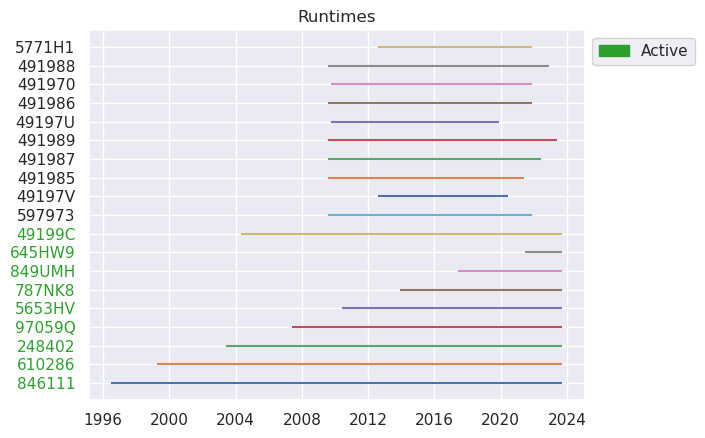

In [4]:
y = list(range(len(df_prices.columns)))
xmin = [min(df_prices[col].dropna().index) for col in df_prices.columns]
xmax = [max(df_prices[col].dropna().index) for col in df_prices.columns]

fig, ax = plt.subplots()
lines = plt.hlines(y=y,xmin=xmin,xmax=xmax,colors=sns.color_palette())
ax.set_yticks(list(range(len(df_prices.columns))))
ax.set_yticklabels(df_prices.columns)

for t in ax.yaxis.get_ticklabels():
    if df_info.loc[t.get_text(),"ACTIVE"] == "Active":
        t.set_color("tab:green")

plt.legend(handles=[mpatches.Patch(color="tab:green",label="Active")])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_title("Runtimes")

plt.show()

### Historical Prices

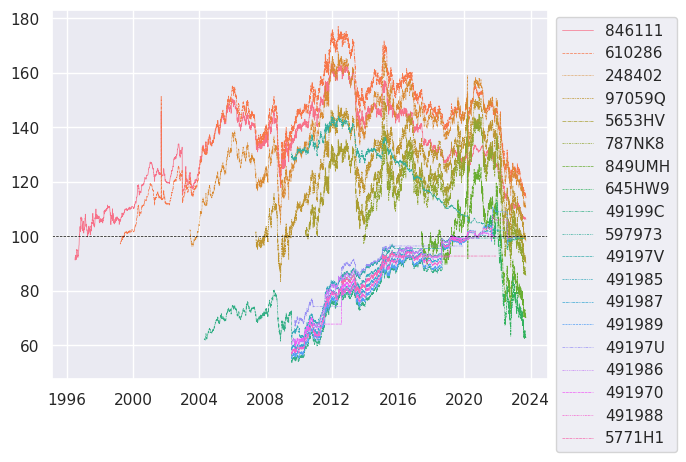

In [12]:
fig, ax = plt.subplots()
sns.lineplot(df_prices,linewidth=0.5,ax=ax)
ax.axhline(y=100,linestyle="--",color="black",linewidth=0.5)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

In [13]:
bond_dropdown = widgets.Dropdown(description="Bond",options=list(map(lambda t:t[::-1],list(df_info[["NAME"]].itertuples(name=None)))))

def plot_hist_prices(bond):
    fig,ax = plt.subplots()
    sns.lineplot(df_prices,x=df_prices.index,y=bond,ax=ax,label=bond)
    ax.axhline(y=100,linestyle="--",color="black",linewidth=1)
    ax.set_ylabel("")
    ax.set_xlabel("")
    plt.show()

    display(df_info.loc[bond,:])

out_0 = widgets.interactive_output(plot_hist_prices,{"bond":bond_dropdown})
display(bond_dropdown,out_0)

Dropdown(description='Bond', options=(('CANADA 1995 4 1/4% 01/12/26 INDXLK.', '846111'), ('CANADA 1999 4% 01/1…

Output()

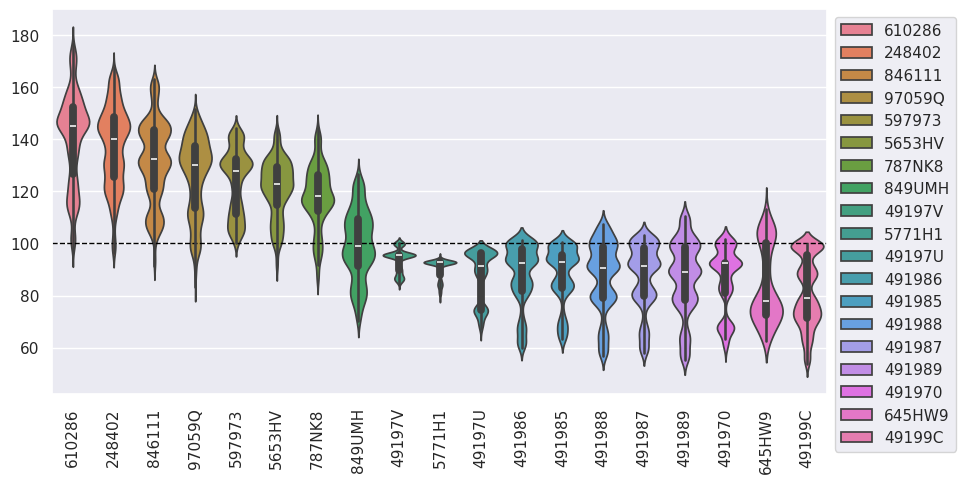

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=100,linestyle="--",color="black",linewidth=1)
sns.violinplot(df_prices.reindex(df_prices.mean().sort_values(ascending=False).index, axis=1),ax = ax,legend=True)
plt.xticks(rotation=90)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

### Interest Rates

,description
id,
V80691311,Prime rate
V80691333,1-year Conventional mortgage
V80691334,3-year Conventional mortgage
V80691335,5-year Conventional mortgage
V80691339,1-year Guaranteed investment certificates
V80691340,3-year Guaranteed investment certificates
V80691341,5-year Guaranteed investment certificates
V80691336,5-year personal fixed term
V80691337,"Daily Interest Savings (balances over $100,000)"


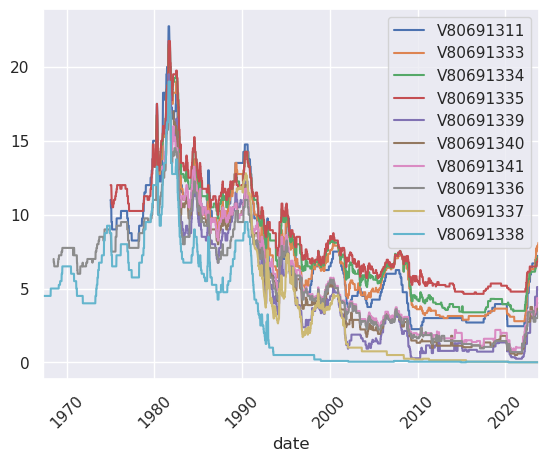

In [15]:
df_interest = pd.read_csv("data/chartered_bank_interest.csv",index_col="date",parse_dates=True)
df_interest_info  =  pd.read_csv("data/chartered_bank_interest_info.csv",index_col = "id")
df_interest_info.replace(np.nan,"",inplace=True)
df_interest_info["description"] = df_interest_info["label"]+" "+df_interest_info["description"]
df_interest_info = df_interest_info.loc[:,["description"]]

display(df_interest_info)

fig, ax = plt.subplots()
df_interest.plot(ax = ax)
plt.xticks(rotation=45)
plt.show()

### Bond Market Prices vs. Interest Rates

In [16]:
interest_rate_dropdown = widgets.Dropdown(description="Interest",options=list(map(lambda t: t[::-1],df_interest_info[["description"]].itertuples(name=None))))

def plot_price_vs_interest_rate(bond,rate,**kwargs):
    min_date,max_date = min(df_prices[bond].dropna().index), max(df_prices[bond].dropna().index)
    df_interest_temp = df_interest.loc[min_date:max_date,:]
    
    with sns.axes_style("dark"):
        fig,ax = plt.subplots()
        ax1 = plt.twinx()
        
    sns.lineplot(df_prices,x=df_prices.index,y=bond,ax=ax,)
    ax.axhline(y=100,linestyle="--",color="black",linewidth=.5)
    
    sns.lineplot(df_interest_temp,x=df_interest_temp.index,y=rate,ax=ax1,color="tab:orange")

    ax.set_ylabel("Bond Price",color="tab:blue")
    ax1.set_ylabel("Interest Rate",color="tab:orange")
    ax.set_xlabel("")
    ax1.set_xlabel("")
    
    plt.show()
    display(df_info.loc[bond,:])


out_1 = widgets.interactive_output(plot_price_vs_interest_rate,{"bond":bond_dropdown,"rate":interest_rate_dropdown})
display(bond_dropdown,interest_rate_dropdown,out_1)

Dropdown(description='Bond', index=10, options=(('CANADA 1995 4 1/4% 01/12/26 INDXLK.', '846111'), ('CANADA 19…

Dropdown(description='Interest', options=(('Prime rate ', 'V80691311'), ('1-year Conventional mortgage', 'V806…

Output()

# Bond Evaluation

In [10]:
class Bond():
    def __init__(self,*args,**kwargs):
        pass
    def cashflows(self,evaluation_date,*args,**kwargs):
        """
        freq: Frequency of coupon payments: semi-annual: freq=2, annual: freq=1, Zero Bond:freq = 0 
        c: coupon: c = 100 * r_pa/freq if freq > 0 else 0
        r_pa: nominal rate p.a.
        r_pd: nominal rate p.d.: r_pd = r_pa/365
        delta_d: datediff in days: cashflow_date - evaluation_date
        """
        
        pass
    def ytm(self,evaluation_date):
        #scipy.optimize.newton
        pass
    def break_even_rate(self,other,*args,**kwargs):
        pass
    def __repr__(self):
        return self.name